## Truncated octahedron model
* pure python model using Lebedev quadrature
* SASView file model is octa_general.py


### Lebedev library
* need pylebedev library installed in the python environnement
https://pypi.org/project/pylebedev/ 
* installation using: pip install pylebedev in a terminal


In a global python environnement, pylebedev is installed here:
* C:\Users\Administrateur\AppData\Local\Programs\Python\Python310\Lib\site-packages\pylebedev

Before using the model with Sasview GUI, copy the pylebedev folder here:
* C:\SasView-6.0.0\pylebedev

### location of the python model file:
* in a global environnement, put it directly here:
C:\Users\Administrateur\AppData\Local\Programs\Python\Python310\Lib\site-packages\sasmodels\models
* For usage with SASView GUI, put it in your user plugin folder here:
C:\Users\Administrateur\.sasview\plugin_models


#### Possible improvements of the model:
Code in: octa_general.py
* option Iq.vectorise=False 
* find a way to code the intensity allowing option Iq.vectorized= True ???
##### Solve division by zero ?
* divergence in the amplitude for Qx=Qy, Qy=Qz or Qz=Qx with a division by zero!
* Solution here is adding two successive rotations with 'random' fixed values (angle tetaz=0.01076 around z-axis and angle tetax=0.0203 around x-axis) for the quadrature points. Doing so, all sample points avoid the divergence. :)
* Find a better solution ??? (in function amp3D(qx,qy,qz))

### Beginning of code

import all the packages
* need installation of sasmodels, sasdata, bumps in your python environnement

In [1]:
import numpy as np

# import sasmodels
import sasmodels
import sasmodels.core
import sasmodels.data
import sasmodels.bumps_model

import sasdata
from sasdata.dataloader.loader import Loader

from sasmodels.core import load_model
from sasmodels.bumps_model import Model, Experiment
from sasmodels.data import load_data, empty_data1D, plot_data

import bumps
import bumps.fitters
import bumps.names
import bumps.fitproblem


import os
#import periodictable
#import periodictable.nsf
import tol_colors as tc # colorblind safe color palettes


"""
import matplotlib.pyplot and set custom default settings for plots
"""
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

plt.rc('font', size=14) # default fontsize
plt.rc('axes', titlesize=16)
plt.rc('axes', labelsize=16)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('legend', fontsize=14)
plt.rc('legend', title_fontsize=14)
plt.rc('figure', titlesize=18)
plt.rc("figure", figsize=(5,5))
plt.rc("lines", linewidth=3)


# use colorblind safe colors:
plt.rc('axes', prop_cycle=plt.cycler('color', list(tc.tol_cset('muted'))))
try:
    plt.cm.register_cmap('tc_iridescent', tc.tol_cmap('iridescent'))
except:
    pass
plt.rc('image', cmap='tc_iridescent')

C:\Users\Administrateur\AppData\Local\Temp\ipykernel_3180\1856067786.py:33: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')


Load a 1D data file

* 70.dat is a data set from gold octahedrons dilute suspension (Form Factor)
* load the data from an example .dat file into a numpy array
* transform the numpy array into a suitable 1D data set using `sasmodels.data.Data1D`
* possiblity to reduce the number of data points by slicing

1236
206


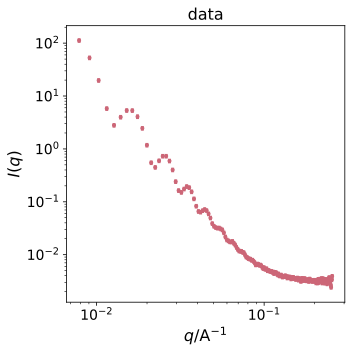

In [22]:
filename='./data-octa/70.dat' #data from octa paper 
data_np = np.loadtxt(filename, skiprows=40)

number_of_data=data_np.shape[0] #total number of data points in the file
print(number_of_data)

slicing_step=6 # step of slicing 

# new error bars: 10 % of intensity values
coeff=0.1
#data = sasmodels.data.Data1D(x=data_np[:,0], y=data_np[:,1], dy=data_np[:,2])
data = sasmodels.data.Data1D(x=data_np[0:number_of_data:slicing_step,0], 
                             y=data_np[0:number_of_data:slicing_step,1], 
                             dy=coeff*data_np[0:number_of_data:slicing_step,1])

number_of_data_new=data.x.shape[0]
print(number_of_data_new)

sasmodels.data.plot_data(data)

Save the data file after appyling slicing and modifying error bars

In [23]:
newfilename='./data-octa/70-new.dat'

with open(newfilename, "w") as f:
    f.write("raw data file is: 70.dat\n")
    f.write("number of data points: \t"+str(number_of_data_new)+"\n")

with open(newfilename, "a") as fa:
    for i in range(0,number_of_data_new):
        line_to_write=str(data.x[i])+"\t"+str(data.y[i])+"\t"+str(data.dy[i])+"\n"
        fa.write(line_to_write)


### Fit with the model 
* create the computation `kernel` selecting the `octa_general` model
* create the `modelfit` interfaced with bump module
* create the `experiment`, containing both data and model

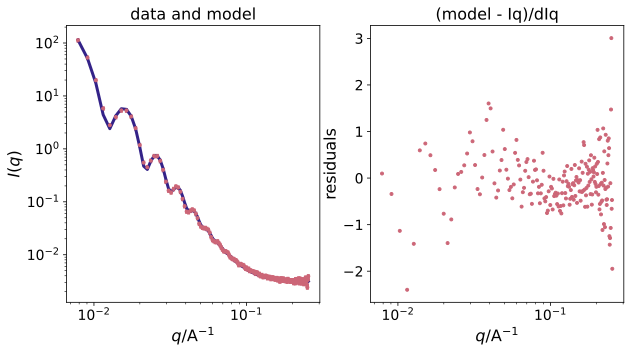

In [26]:
kernel = sasmodels.core.load_model("octa_general")
params = {
    "background": 0.003,
    "scale": 2.86e-6,
    "length_a": 538,
    "t":0.75,
    "n_order":20,
    "length_a_pd_type": 'gaussian', #type of polydispersity function
    "length_a_pd": 0.06, #polydispersity
    "length_a_pd_n": 10, #number of steps in polydispersity
    "length_a_pd_nsigma": 3, #range as multiple of sigma

}
modelfit = sasmodels.bumps_model.Model(kernel, **params)
experiment = sasmodels.bumps_model.Experiment(data=data, model=modelfit)

plt.figure(figsize=(10,5))
experiment.plot()

step 1 cost 0.764(23)
                              background ....|.....      0.003 in (0.002,0.004)
                                length_a .......|..        538 in (500,550)
                                   scale ........|.   2.86e-06 in (2e-06,3e-06)
                                       t .|........       0.75 in (0.7,1)
step 2 cost 0.743(23)
step 3 cost 0.743(23)
                              background .....|.... 0.00303102 in (0.002,0.004)
                                length_a .......|..    536.297 in (500,550)
                                   scale ........|. 2.83675e-06 in (2e-06,3e-06)
                                       t .|........   0.756633 in (0.7,1)
step 4 cost 0.743(23)
step 5 cost 0.742(23)
                              background .....|.... 0.00303076 in (0.002,0.004)
                                length_a .......|..    536.224 in (500,550)
                                   scale ........|. 2.83603e-06 in (2e-06,3e-06)
                                

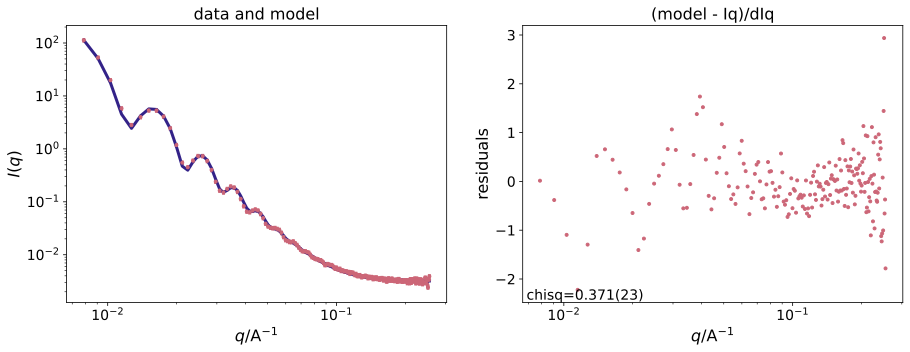

In [27]:
#list of the fiting parameters with their fiting range
modelfit.scale.range(2e-6, 3e-6)
modelfit.background.range(0.002, 0.004)
modelfit.length_a.range(500, 550)
#modelfit.length_a_pd.range(0.055,0.065)
modelfit.t.range(0.7,1)

problem = bumps.fitproblem.FitProblem(experiment)

results = bumps.fitters.fit(problem, 
                            method='lm', 
                            steps=20, 
                            ftol=1.5e-06, 
                            xtol=1.5e-06, 
                            verbose=True)

plt.figure(figsize=(15,5))
problem.plot()
print(problem.summarize())

step 1 cost 0.825(19)
                              background ....|.....      0.003 in (0.002,0.004)
                                length_a .......|..        538 in (500,550)
                             length_a_pd ....|.....       0.06 in (0.055,0.065)
                                   scale ........|.   2.86e-06 in (2e-06,3e-06)
                                       t .|........       0.75 in (0.7,1)
step 2 cost 0.821(19)
                              background .....|.... 0.00301629 in (0.002,0.004)
                                length_a .......|..    538.328 in (500,550)
                             length_a_pd .....|....  0.0609377 in (0.055,0.065)
                                   scale ........|. 2.85356e-06 in (2e-06,3e-06)
                                       t .|........   0.748624 in (0.7,1)
step 3 cost 0.821(19)
                              background .....|.... 0.00301628 in (0.002,0.004)
                                length_a .......|..    538.181 in (500,55

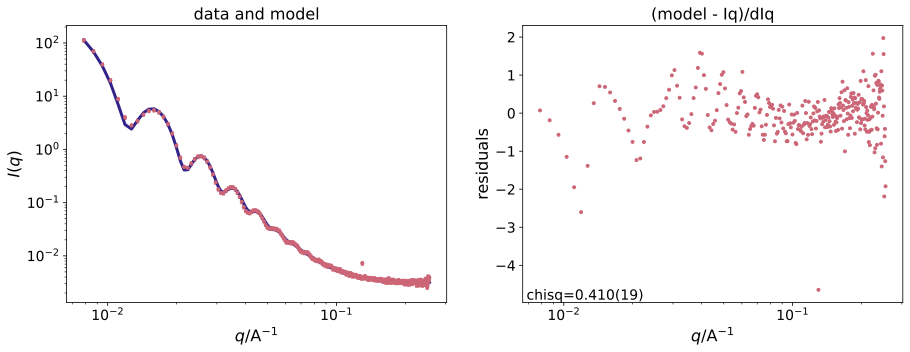

In [ ]:

#list of the fiting parameters with their fiting range
modelfit.scale.range(2e-6, 3e-6)
modelfit.background.range(0.002, 0.004)
modelfit.length_a.range(500, 550)
modelfit.length_a_pd.range(0.055,0.065)
modelfit.t.range(0.7,1)

problem = bumps.fitproblem.FitProblem(experiment)

results = bumps.fitters.fit(problem, 
                            method='lm', 
                            steps=50, 
                            ftol=1.5e-06, 
                            xtol=1.5e-06, 
                            verbose=True)

plt.figure(figsize=(15,5))
problem.plot()
print(problem.summarize())

The current value of all parameters can always be called using `model.state()`:

In [28]:
modelfit.state()

{'scale': 2.8360166322895953e-06,
 'background': 0.003030748287178515,
 'sld': 128,
 'sld_solvent': 9.4,
 'length_a': 536.2227279944374,
 'length_a_pd': 0.06,
 'length_a_pd_n': 10,
 'length_a_pd_nsigma': 3,
 'b2a_ratio': 1,
 'b2a_ratio_pd': 0.0,
 'b2a_ratio_pd_n': 35.0,
 'b2a_ratio_pd_nsigma': 3.0,
 'c2a_ratio': 1,
 'c2a_ratio_pd': 0.0,
 'c2a_ratio_pd_n': 35.0,
 'c2a_ratio_pd_nsigma': 3.0,
 't': 0.7576707927682824,
 't_pd': 0.0,
 't_pd_n': 35.0,
 't_pd_nsigma': 3.0,
 'n_order': 20,
 'up_frac_i': 0.0,
 'up_frac_f': 0.0,
 'up_angle': 0.0,
 'up_phi': 0.0,
 'sld_M0': 0.0,
 'sld_mtheta': 0.0,
 'sld_mphi': 0.0,
 'sld_solvent_M0': 0.0,
 'sld_solvent_mtheta': 0.0,
 'sld_solvent_mphi': 0.0,
 'length_a_pd_type': 'gaussian',
 'b2a_ratio_pd_type': 'gaussian',
 'c2a_ratio_pd_type': 'gaussian',
 't_pd_type': 'gaussian'}

In [29]:
print(problem.summarize())

                              background .....|.... 0.00303075 in (0.002,0.004)
                                length_a .......|..    536.223 in (500,550)
                                   scale ........|. 2.83602e-06 in (2e-06,3e-06)
                                       t .|........   0.757671 in (0.7,1)


In [30]:
results.x

array([3.03074829e-03, 5.36222728e+02, 2.83601663e-06, 7.57670793e-01])

In [31]:
problem.labels()

['background', 'length_a', 'scale', 't']

In [32]:
problem.fitness.model.state()

{'scale': 2.8360166322895953e-06,
 'background': 0.003030748287178515,
 'sld': 128,
 'sld_solvent': 9.4,
 'length_a': 536.2227279944374,
 'length_a_pd': 0.06,
 'length_a_pd_n': 10,
 'length_a_pd_nsigma': 3,
 'b2a_ratio': 1,
 'b2a_ratio_pd': 0.0,
 'b2a_ratio_pd_n': 35.0,
 'b2a_ratio_pd_nsigma': 3.0,
 'c2a_ratio': 1,
 'c2a_ratio_pd': 0.0,
 'c2a_ratio_pd_n': 35.0,
 'c2a_ratio_pd_nsigma': 3.0,
 't': 0.7576707927682824,
 't_pd': 0.0,
 't_pd_n': 35.0,
 't_pd_nsigma': 3.0,
 'n_order': 20,
 'up_frac_i': 0.0,
 'up_frac_f': 0.0,
 'up_angle': 0.0,
 'up_phi': 0.0,
 'sld_M0': 0.0,
 'sld_mtheta': 0.0,
 'sld_mphi': 0.0,
 'sld_solvent_M0': 0.0,
 'sld_solvent_mtheta': 0.0,
 'sld_solvent_mphi': 0.0,
 'length_a_pd_type': 'gaussian',
 'b2a_ratio_pd_type': 'gaussian',
 'c2a_ratio_pd_type': 'gaussian',
 't_pd_type': 'gaussian'}